In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Section 1: Likelihood Sampling

Likelihood is the value of the PDF for the model on the multidimensional probability distribution that represents the data. 
Below, we perform maximisation for small-angle neutron scattering data. 

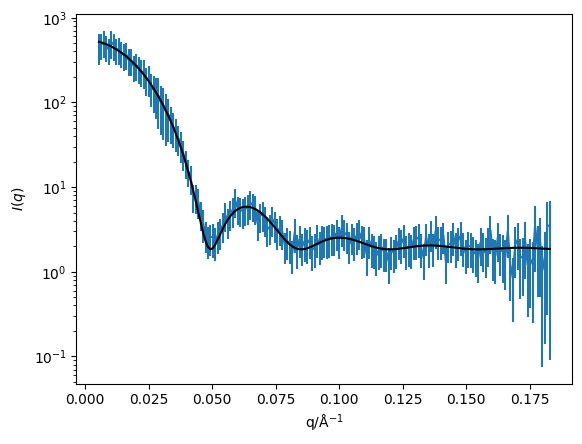

In [2]:
from scipy.stats import multivariate_normal
from scipy.optimize import differential_evolution

q, i, di = np.loadtxt('sans_iofq.dat', unpack=True)

def sphere(q, r, delta_rho, bkg):
    """
    The function for the form factor of a sphere. 
    
    Parameters
    ----------
    q: 
        q-vectors to calculate for.
    
    Returns
    -------
    : 
        The modelled intensity.
    """
    qr = q * r
    V = 4 / 3 * np.pi * r ** 3
    return 2.1e-4 / V * (3 * V * delta_rho * (np.sin(qr) - qr * np.cos(qr)) / ((qr) ** 3)) ** 2 + bkg

mvn = multivariate_normal(mean=i, cov=np.diag(di ** 2))

def nll(theta):
    """
    Negative log-likelihood.
    
    :param a: The parameters being optimised.
    :returns: The negative log PDF value.
    """
    return -mvn.logpdf(sphere(q, *theta))

result = differential_evolution(nll, ((10, 1000), (0, 4), (0, 10)))

fig, ax = plt.subplots()
ax.errorbar(q, i, di)
ax.plot(q, sphere(q, *result.x), 'k', zorder=10)
ax.set_yscale('log')
ax.set_xlabel('q/Å$^{-1}$')
ax.set_ylabel('$I(q)$')
plt.show()

However, this point represents only the maximum of the likelihood probability distribution function. 
It would be preferable to understand the full structure of the probability distribution. 
This can be achieved using a sampling approach; in particular, we will use Markov chain Monte Carlo (MCMC) sampling as implemented in the [`emcee` python package](https://emcee.readthedocs.io/en/stable/). 

MCMC sampling is a powerful tool that gives a complete distribution of the likelihood probability distribution function. 
The PDF is n-dimensional, where n is the number of optimised parameters. 
Let's look at how we use `emcee` for likelihood sampling. First, we need to import the package and define the number of parameters we are sampling and how many "walkers" we will use. 
The walkers are the individual Markov chains used for the sampling. 

In [3]:
import emcee

ndim = len(result.x)
nwalkers = 100

## Log-likelihood Function

The `emcee` package samples the log-probability distribution, not the negative. 
Therefore, we must create a function called `log_likelihood` that takes a single variable (the parameters) and returns the `logpdf` for the model (with said parameters). 

In [4]:
def log_likelihood(theta):
    """
    Positive log-likelihood.
    
    :param a: The parameters being optimised.
    :returns: The negative log PDF value.
    """
    return mvn.logpdf(sphere(q, *theta))

With the dimension and walker values and the `log_likelihood` function, we can set up the sampler object, which takes inputs of the number of walkers, the number of dimensions, and the probability distribution to sample.

In [5]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

The best results are obtained when the Markov chains are started close to the maximum of the likelihood. 
Therefore, we will slightly permute the optimal values (so that each walker starts from a different place) and use this as an input. 

In [6]:
p0 = result.x + result.x * 0.01 * np.random.randn(nwalkers, ndim)

The sampling is then run for 2000 steps, as shown below. 

In [7]:
state = sampler.run_mcmc(p0, 2000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:30<00:00, 65.93it/s]


The `get_chain()` method for the sampler will return the values each chain has sampled. 

Notice that the shape of the chain is the number of samples by the number of walkers by the number of parameters. 

In [8]:
chain = sampler.get_chain()
print(chain.shape)

(2000, 100, 3)


In [9]:
samples = 2000
parameter=3

In [10]:
chain[:,0,0].shape

(2000,)

## Plot the Chains

Plot the chains as a function of the samples for each of the three parameters. 

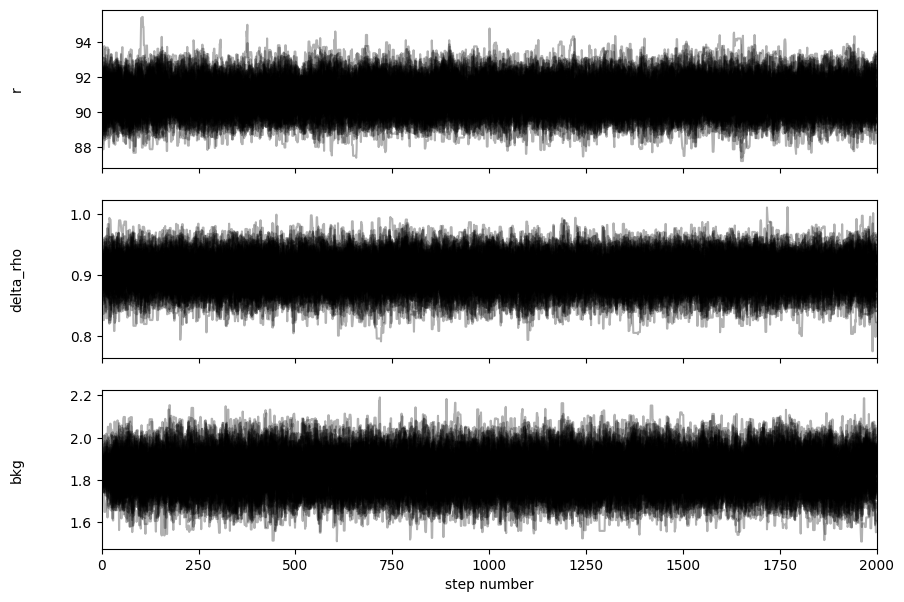

In [11]:
fig, axes = plt.subplots(ndim, figsize=(10,7),sharex=True)
samples = sampler.get_chain()
labels = ['r','delta_rho','bkg']
for n in range(ndim):
    ax=axes[n]
    ax.plot(chain[:,:,n],'k',alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[n])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.show()

The walkers all start relatively close to the maximum of the distribution. 
Therefore, we would like to know if the walkers have explored the complete distribution before we start to conclude our analyses. 
The figures above should show that there appears to be good coverage of the distribution, i.e., there are no weird bumps or wiggles in the chains. 
We can also estimate the [integrated autocorrelation time](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/#autocorr), which is a valuable metric for estimating when the "burn in" of convergence has been reached. 

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

[32.61733712 31.37096451 35.04724192]


The integrated autocorrelation time is about 30 to 40 steps for all three parameters. 
The suggestion from [Goodman & Weare](https://msp.org/camcos/2010/5-1/p04.xhtml) is that around twice the integrated autocorrelation time should be discarded from the start of all chains, and the chains should be thinned by half this time. 

In [13]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(12600, 3)


Thinning by 15 means that only every 15th sample is used.
Additionally, in the above function, the chains are also flattened so that all of the chains are combined. 
We can visualise the likelihood distribution using the `corner` package, which provides "corner" plots.

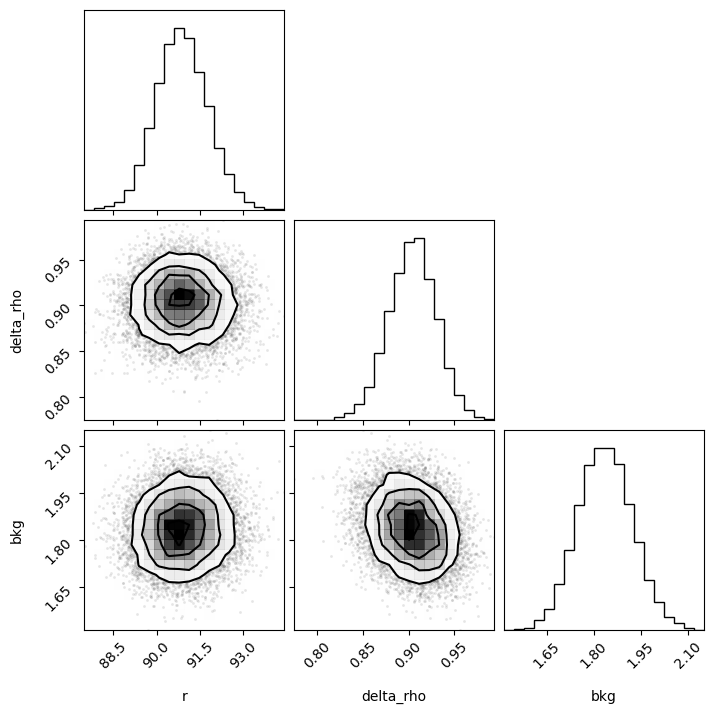

In [14]:
from corner import corner

labels = ['r', 'delta_rho', 'bkg']

corner(flat_samples, labels=labels)
plt.show()

A popular way to represent the data and this probabilistic likelihood model is using random samples from the chain to emulate the appearance of a distribution of models. 

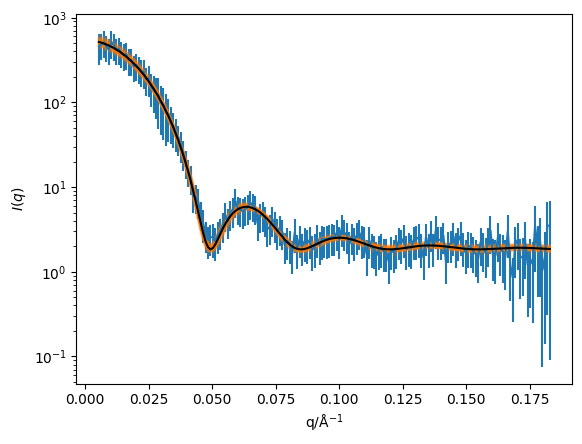

In [15]:
fig, ax = plt.subplots()
ax.errorbar(q, i, di)
ax.plot(q, sphere(q, *np.mean(flat_samples, axis=0)), 'k', zorder=10)
for n in np.random.randint(flat_samples.shape[0], size=100):
    ax.plot(q, sphere(q, *flat_samples[n]), 'C1', alpha=0.1)
ax.set_yscale('log')
ax.set_xlabel('q/Å$^{-1}$')
ax.set_ylabel('$I(q)$')
plt.show()

## Parametric Uncertainties and Correlations

Using the `flat_samples` object, it is possible to calculate the mean and standard deviation for each sampled parameter. 
In calculating these parameters, the standard deviation represents the parametric "inverse" uncertainty, i.e., the confidence that we have about our estimate of the variable. 

In [16]:
flat_samples.mean()

31.20860421549461

In [17]:
flat_samples.std()

42.20256396827003

Then, calculate the [correlation coefficient](https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html) between the parameters. 
What does this tell you about the parameters?

In [18]:
np.corrcoef(flat_samples.T)

array([[ 1.        , -0.0227824 ,  0.05767062],
       [-0.0227824 ,  1.        , -0.2368055 ],
       [ 0.05767062, -0.2368055 ,  1.        ]])

## Section 2: Bayesian Modelling

Building on our understanding of probabilistic modelling, we will now consider Bayesian modelling. 
Bayesian modelling is where we allow our prior knowledge about the system to influence the results of our analysis. 
Some may argue that any analytical modelling we do is "Bayesian" in nature, as we use our prior knowledge that the data should follow some functional relationship, typically that we draw from underlying theory. 

The backbone of Bayesian modelling is Bayes theorem, which has the following form:

$$
p(\Theta|D) = \frac{p(D|\Theta) p(\Theta)}{p(D)}, 
$$

which we can read as the probability of some set of parameters, $\Theta$ given our data, $D$ ($p(\Theta|D)$, the posterior), is equal to the product of the likelihood (the probability of the data given some parameters, $p(D|\Theta)$) and the prior probability of the parameters, $p(\Theta)$, divided by the probability of the data, $p(D)$ being observed.

We are already familiar with the likelihood. However, the prior probability and the probability of the data could be more familiar. 
The latter is not a problem for us if we want to compute the posterior distributions of $\Theta$ because it does not vary with $\Theta$ and therefore, it is simply a constant of proportionality, 

$$
p(\Theta|D) \propto p(D|\Theta) p(\Theta),
$$

The prior probability is a probabilistic description of what we already know about the parameters, $\Theta$. 
We can define these with objects from `scipy.stats`. 

In [19]:
from scipy.stats import norm, uniform

r_prior = norm(loc=100, scale=2)
delta_rho_prior = norm(loc=1, scale=5)
bkg_prior = uniform(loc=0, scale=1.9)

priors = [r_prior, delta_rho_prior, bkg_prior]

Using the `rvs` method for each distribution, we can plot the prior probability distribution using `corner` again. 

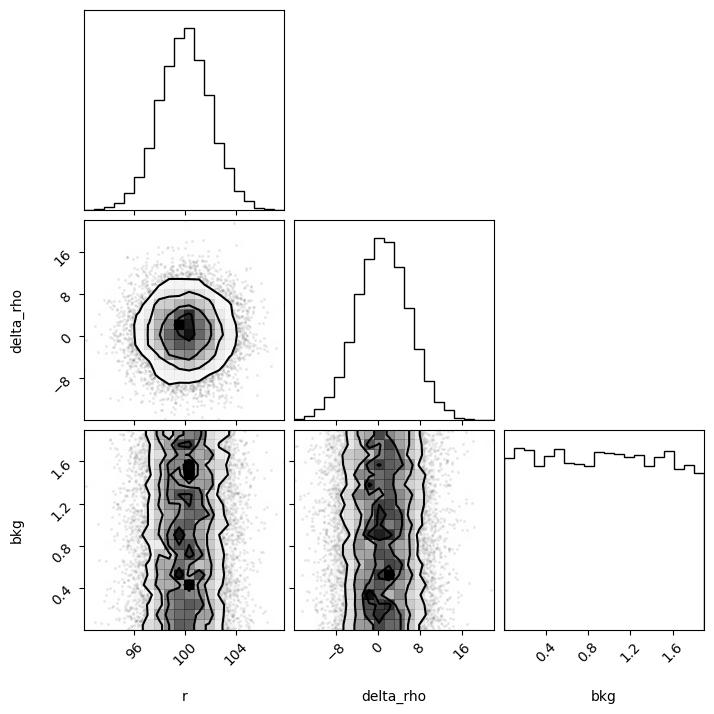

In [20]:
corner(np.array([p.rvs(10000) for p in priors]).T, labels=labels)
plt.show()

The $r$ and $\Delta \rho$ values are normally distributed. However, the $\text{bkg}$ follows a uniform distribution, where all values from 0 to 1.9 are equally likely. 

## Function for log-Prior Probability

Write a function called `log_prior` that takes an input array. 
This input array, `theta`, will be an array of values, one for each parameter. 
The function should return the sum of the `logpdf` of each priors given the parameter's input value. 

In [21]:
def log_prior(theta):
    """
    Returns the sum of the log-prior for the given parameters, theta.
    
    :param: theta: The currently sampled value of the parameters
    :type theta: np.ndarray
    
    :return: Sum of log-priors
    :rtype: float
    """
    log_p = 0
    for p, t in zip(priors, theta):
        log_p += p.logpdf(t)
    return log_p

We can compute the log-posterior using the function defined above and the likelihood function defined earlier.

In [22]:
def log_posterior(theta):
    """
    Returns the log-psoterior, as the sum of the log-prior and log-likelihood.
    
    :param: theta: The currently sampled value of the parameters
    :type theta: np.ndarray
    
    :return: log-posterior value
    :rtype: float
    """
    return log_prior(theta) + log_likelihood(theta)

def nlp(theta):
    """
    Returns the negative log-posterior.
    
    :param: theta: The currently sampled value of the parameters
    :type theta: np.ndarray
    
    :return: Negative log-posterior value
    :rtype: float"""
    return -log_posterior(theta)


Before sampling, we again use our optimisation algorithm to find the maximum of the posterior distribution. 
We call this the `map`, or maximum *a posteriori*.

map = differential_evolution(nlp, ((10, 1000), (0, 4), (0, 10)))
print(map.x)

The sampler is then constructed and sampled in the same fashion as previously. 
However, this time, we sample the log-posterior instead of the log-likelihood. 

In [23]:
p0 = result.x + result.x * 0.01 * np.random.randn(nwalkers, ndim)
bayes_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
state = bayes_sampler.run_mcmc(p0, 2000, progress=True)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:29<00:00, 22.45it/s]


Once completed, the sampling shows a similar autocorrelation time to the log-likelihood sampling. 

In [24]:
tau = bayes_sampler.get_autocorr_time()
print(tau)

[34.35293856 32.78819518 34.75980926]


Therefore, we can use the same discard and thinning values as previously when the flat chains are found.

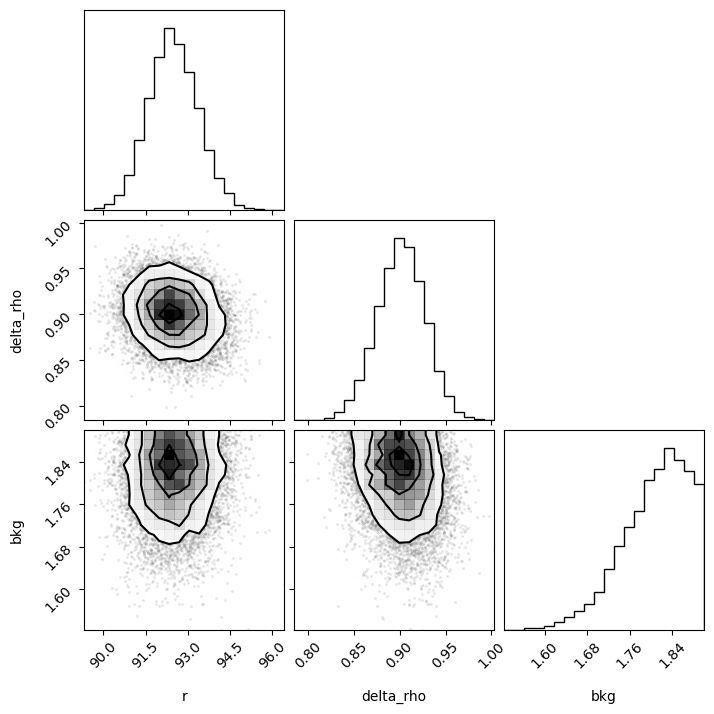

In [25]:
bayes_flat_samples = bayes_sampler.get_chain(discard=100, thin=15, flat=True)
corner(bayes_flat_samples, labels=labels)
plt.show()

## The Effect of the Prior Probability

We can calculate the means and standard deviation for the posterior distribution dimensions. 
What difference has the prior probability had on the results?

In [26]:
np.mean(bayes_flat_samples, axis=0), np.std(bayes_flat_samples, axis=0)

(array([92.48479716,  0.90159657,  1.80765365]),
 array([0.87444786, 0.02596   , 0.06172762]))

Similar to the result of the likelihood sampling, we can plot the posterior as a series of lines over the data. 

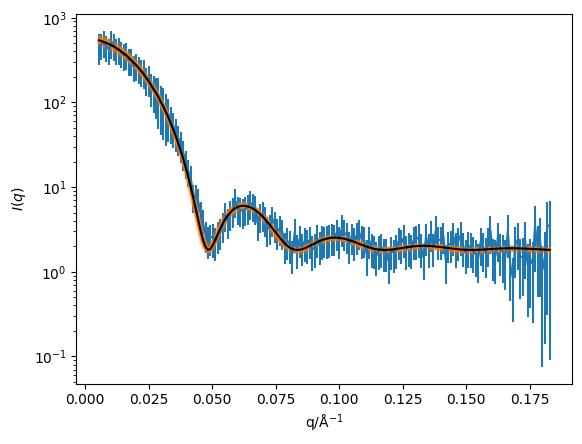

In [27]:
fig, ax = plt.subplots()
ax.errorbar(q, i, di)
ax.plot(q, sphere(q, *np.mean(bayes_flat_samples, axis=0)), 'k', zorder=10)
for n in np.random.randint(bayes_flat_samples.shape[0], size=100):
    ax.plot(q, sphere(q, *bayes_flat_samples[n]), 'C1', alpha=0.1)
ax.set_yscale('log')
ax.set_xlabel('q/Å$^{-1}$')
ax.set_ylabel('$I(q)$')
plt.show()